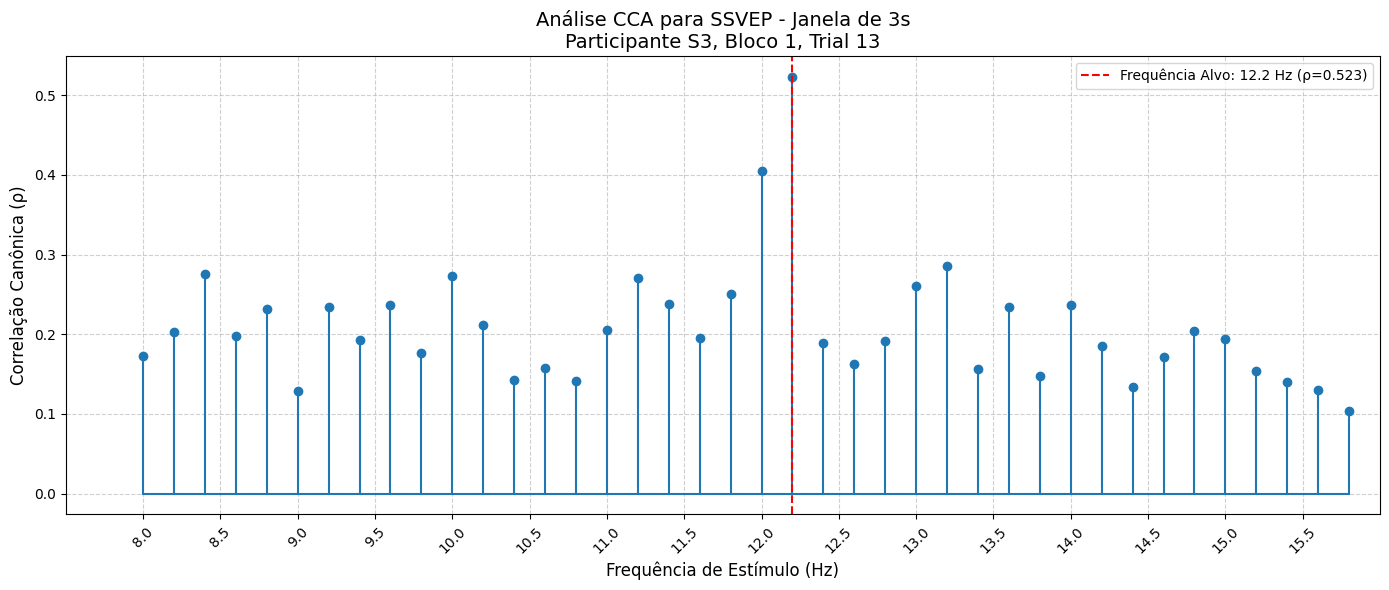

Frequência alvo: 12.2 Hz
Frequência detectada: 12.2 Hz
Correlação máxima (ρ): 0.5227


In [ ]:
# questão A

import numpy as np
import scipy.io as sio
from sklearn.cross_decomposition import CCA
import matplotlib.pyplot as plt

# 1. Carregar dados do participante S3
data = sio.loadmat('S3.mat')
eeg_data = data['data']  # Formato: (64 canais, 1500 amostras, 40 trials, 6 blocos)
fs = 250  # Frequência de amostragem

# 2. Definir canais occipitais (baseado na sua lista confirmada)
occipital_indices = [47, 53, 54, 55, 56, 57, 60, 61, 62]  # Índices Python (0-based)

# 3. Carregar frequências dos estímulos (arquivo Freq_Phase.mat)
freq_phase = sio.loadmat('Freq_Phase.mat')
frequencies = freq_phase['freqs'].flatten()  # 40 frequências (8-15.8 Hz)
phases = freq_phase['phases'].flatten()  # Fases correspondentes

# 4. Parâmetros da análise
window_start = 0.64  # 0.5s (início do estímulo) + 0.14s (latência)
window_length = 3  # Janela de 3s
window_samples = int(window_length * fs)
target_trial = 12  # Trial com estímulo em 12.2 Hz (exemplo)
target_block = 0    # Bloco 1 (índice 0 em Python)

# 5. Extrair janela de EEG (0.64s a 3.64s)
start_idx = int(window_start * fs)
end_idx = start_idx + window_samples
eeg_window = eeg_data[occipital_indices, start_idx:end_idx, target_trial, target_block].T

# 6. Gerar sinais de referência (fundamental + 1ª harmônica)
t = np.arange(0, window_length, 1/fs)  # Vetor de tempo
rhos = np.zeros(40)  # Armazenar correlações

for freq_idx, (freq, phase) in enumerate(zip(frequencies, phases)):
    # Criar senos e cossenos nas frequências de interesse
    ref_signals = np.column_stack([
        np.sin(2 * np.pi * freq * t + phase),
        np.cos(2 * np.pi * freq * t + phase),
        np.sin(2 * np.pi * 2 * freq * t + 2 * phase),  # 1ª harmônica
        np.cos(2 * np.pi * 2 * freq * t + 2 * phase)
    ])

    # Aplicar CCA
    cca = CCA(n_components=1)
    cca.fit(eeg_window, ref_signals)
    X_c, Y_c = cca.transform(eeg_window, ref_signals)
    rhos[freq_idx] = np.corrcoef(X_c.T, Y_c.T)[0, 1]

# 7. Plotar resultados (STEM PLOT)
plt.figure(figsize=(14, 6))
markerline, stemlines, baseline = plt.stem(frequencies, rhos, basefmt="C0-", linefmt="C0-", markerfmt="C0o")

# Destacar frequência alvo (12.2 Hz no trial 12)
target_freq = frequencies[target_trial]
plt.axvline(x=target_freq, color='red', linestyle='--', linewidth=1.5,
            label=f'Frequência Alvo: {target_freq:.1f} Hz (ρ={rhos[target_trial]:.3f})')

# Ajustes do gráfico
plt.xlabel('Frequência de Estímulo (Hz)', fontsize=12)
plt.ylabel('Correlação Canônica (ρ)', fontsize=12)
plt.title('Análise CCA para SSVEP - Janela de 3s\nParticipante S3, Bloco 1, Trial 13', fontsize=14)
plt.legend(fontsize=10, loc='upper right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(np.arange(8, 16, 0.5), rotation=45)
plt.xlim(7.5, 16)

plt.tight_layout()
plt.show()

# 8. Resultados numéricos (comentário no relatório)
print(f"Frequência alvo: {target_freq:.1f} Hz")
print(f"Frequência detectada: {frequencies[np.argmax(rhos)]:.1f} Hz")
print(f"Correlação máxima (ρ): {np.max(rhos):.4f}")

Análise por duração:  63%|██████▎   | 12/19 [31:46<20:22, 174.67s/it]/usr/local/lib/python3.11/dist-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
Análise por duração:  68%|██████▊   | 13/19 [34:51<17:45, 177.58s/it]/usr/local/lib/python3.11/dist-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
Análise por duração:  74%|███████▎  | 14/19 [38:26<15:44, 188.94s/it]/usr/local/lib/python3.11/dist-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.wa

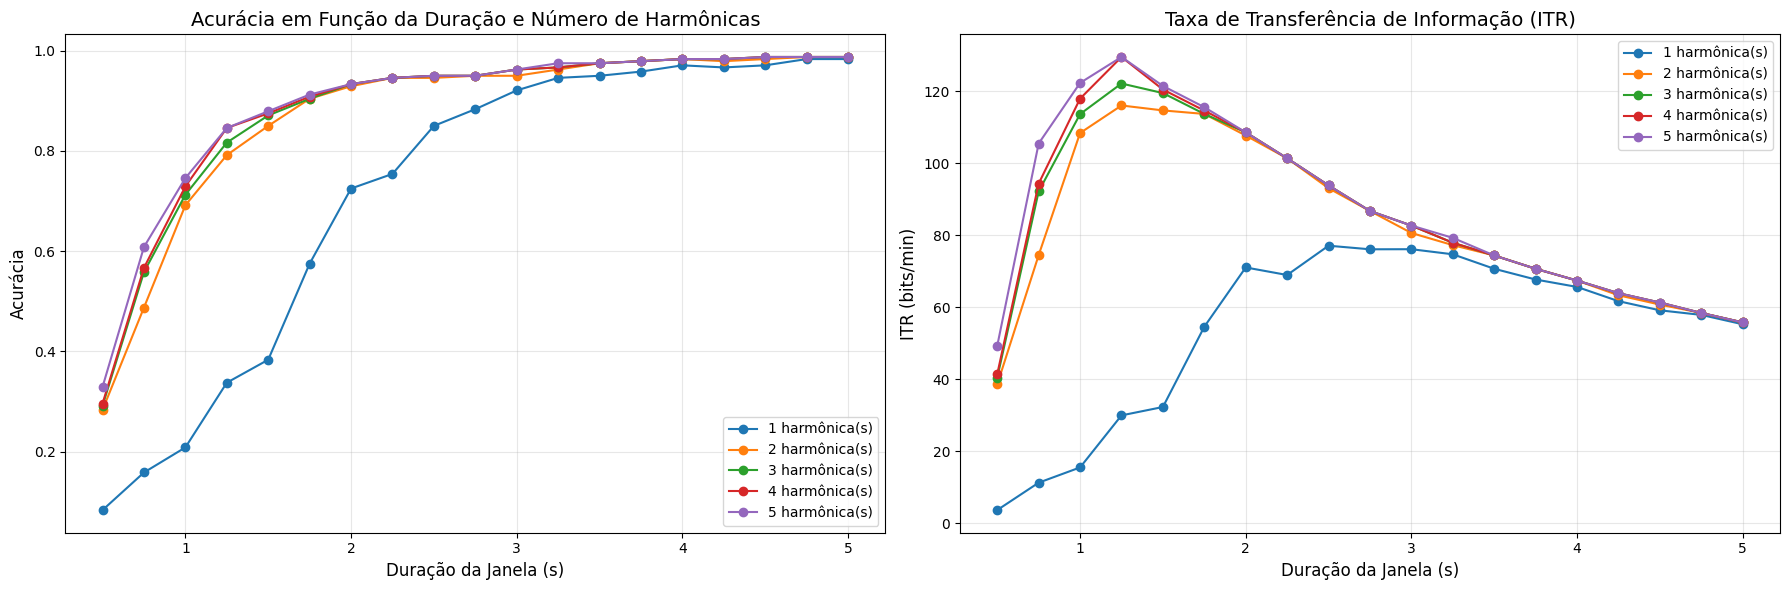

In [ ]:
# questão B

import numpy as np
import scipy.io as sio
from sklearn.cross_decomposition import CCA
import matplotlib.pyplot as plt
from tqdm import tqdm

# 1. Carregar dados
data = sio.loadmat('S3.mat')
eeg_data = data['data']  # (64, 1500, 40, 6)
fs = 250  # Hz

# 2. Parâmetros fixos
occipital_indices = [47, 53, 54, 55, 56, 57, 60, 61, 62]
freq_phase = sio.loadmat('Freq_Phase.mat')
frequencies = freq_phase['freqs'].flatten()
phases = freq_phase['phases'].flatten()
window_start = 0.64
gaze_shift = 0.55

# 3. Configurações variáveis
durations = np.arange(0.5, 5.25, 0.25)
harmonics_list = [1, 2, 3, 4, 5]

# 4. Função CCA corrigida
def compute_cca(eeg, freq, phase, nharmonics, n_samples):
    t = np.arange(n_samples)/fs  # Tempo baseado no número exato de amostras

    ref_signals = []
    for h in range(1, nharmonics + 1):
        ref_signals.append(np.sin(2 * np.pi * h * freq * t + h * phase))
        ref_signals.append(np.cos(2 * np.pi * h * freq * t + h * phase))
    Y = np.column_stack(ref_signals)

    # Verificar consistência
    if eeg.shape[0] != Y.shape[0]:
        min_samples = min(eeg.shape[0], Y.shape[0])
        eeg = eeg[:min_samples, :]
        Y = Y[:min_samples, :]

    cca = CCA(n_components=1)
    cca.fit(eeg, Y)
    X_c, Y_c = cca.transform(eeg, Y)
    return np.corrcoef(X_c.T, Y_c.T)[0, 1]

# 5. Avaliação de desempenho (com barra de progresso combinada)
results = np.zeros((len(durations), len(harmonics_list), 2))

for i, duration in enumerate(tqdm(durations, desc='Análise por duração')):
    n_samples = int(duration * fs)
    start = int(window_start * fs)
    end = start + n_samples

    for j, nharmonics in enumerate(harmonics_list):
        correct = 0

        for block in range(6):
            for trial in range(40):
                eeg_window = eeg_data[occipital_indices, start:end, trial, block].T
                eeg_window = (eeg_window - np.mean(eeg_window, axis=0)) / np.std(eeg_window, axis=0)

                rhos = [compute_cca(eeg_window, f, p, nharmonics, n_samples)
                       for f, p in zip(frequencies, phases)]

                if np.argmax(rhos) == trial:
                    correct += 1

        accuracy = correct / 240  # 40 trials × 6 blocos
        T = gaze_shift + duration
        M = 40

        if accuracy == 1:
            ITR = (np.log2(M)) * (60 / T)
        elif accuracy == 0:
            ITR = 0
        else:
            ITR = (np.log2(M) + accuracy*np.log2(accuracy) +
                  (1-accuracy)*np.log2((1-accuracy)/(M-1))) * (60/T)

        results[i, j, 0] = accuracy
        results[i, j, 1] = ITR

# 6. Visualização dos resultados
plt.figure(figsize=(18, 6))

# Acurácia
plt.subplot(1, 2, 1)
for j, nh in enumerate(harmonics_list):
    plt.plot(durations, results[:, j, 0], 'o-', label=f'{nh} harmônica(s)')
plt.xlabel('Duração da Janela (s)', fontsize=12)
plt.ylabel('Acurácia', fontsize=12)
plt.title('Acurácia em Função da Duração e Número de Harmônicas', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()

# ITR
plt.subplot(1, 2, 2)
for j, nh in enumerate(harmonics_list):
    plt.plot(durations, results[:, j, 1], 'o-', label=f'{nh} harmônica(s)')
plt.xlabel('Duração da Janela (s)', fontsize=12)
plt.ylabel('ITR (bits/min)', fontsize=12)
plt.title('Taxa de Transferência de Informação (ITR)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

Análise por duração: 100%|██████████| 19/19 [1:04:15<00:00, 202.93s/it]


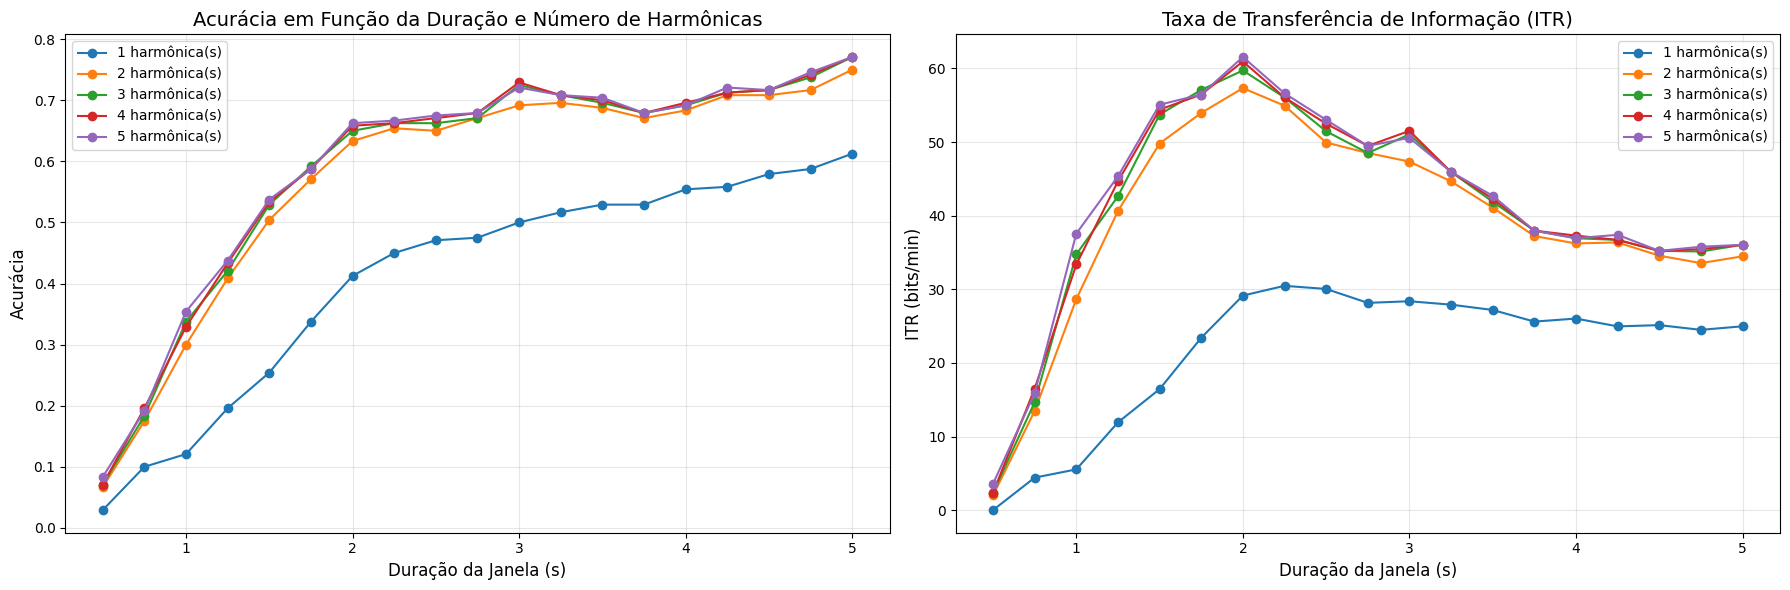

In [ ]:
# questão C

import numpy as np
import scipy.io as sio
from sklearn.cross_decomposition import CCA
import matplotlib.pyplot as plt
from tqdm import tqdm

# 1. Carregar dados
data = sio.loadmat('/content/S21.mat')
eeg_data = data['data']  # (64, 1500, 40, 6)
fs = 250  # Hz

# 2. Parâmetros fixos
occipital_indices = [47, 53, 54, 55, 56, 57, 60, 61, 62]
freq_phase = sio.loadmat('Freq_Phase.mat')
frequencies = freq_phase['freqs'].flatten()
phases = freq_phase['phases'].flatten()
window_start = 0.64
gaze_shift = 0.55

# 3. Configurações variáveis
durations = np.arange(0.5, 5.25, 0.25)
harmonics_list = [1, 2, 3, 4, 5]

# 4. Função CCA corrigida
def compute_cca(eeg, freq, phase, nharmonics, n_samples):
    t = np.arange(n_samples)/fs  # Tempo baseado no número exato de amostras

    ref_signals = []
    for h in range(1, nharmonics + 1):
        ref_signals.append(np.sin(2 * np.pi * h * freq * t + h * phase))
        ref_signals.append(np.cos(2 * np.pi * h * freq * t + h * phase))
    Y = np.column_stack(ref_signals)

    # Verificar consistência
    if eeg.shape[0] != Y.shape[0]:
        min_samples = min(eeg.shape[0], Y.shape[0])
        eeg = eeg[:min_samples, :]
        Y = Y[:min_samples, :]

    cca = CCA(n_components=1)
    cca.fit(eeg, Y)
    X_c, Y_c = cca.transform(eeg, Y)
    return np.corrcoef(X_c.T, Y_c.T)[0, 1]

# 5. Avaliação de desempenho (com barra de progresso combinada)
results = np.zeros((len(durations), len(harmonics_list), 2))

for i, duration in enumerate(tqdm(durations, desc='Análise por duração')):
    n_samples = int(duration * fs)
    start = int(window_start * fs)
    end = start + n_samples

    for j, nharmonics in enumerate(harmonics_list):
        correct = 0

        for block in range(6):
            for trial in range(40):
                eeg_window = eeg_data[occipital_indices, start:end, trial, block].T
                eeg_window = (eeg_window - np.mean(eeg_window, axis=0)) / np.std(eeg_window, axis=0)

                rhos = [compute_cca(eeg_window, f, p, nharmonics, n_samples)
                       for f, p in zip(frequencies, phases)]

                if np.argmax(rhos) == trial:
                    correct += 1

        accuracy = correct / 240  # 40 trials × 6 blocos
        T = gaze_shift + duration
        M = 40

        if accuracy == 1:
            ITR = (np.log2(M)) * (60 / T)
        elif accuracy == 0:
            ITR = 0
        else:
            ITR = (np.log2(M) + accuracy*np.log2(accuracy) +
                  (1-accuracy)*np.log2((1-accuracy)/(M-1))) * (60/T)

        results[i, j, 0] = accuracy
        results[i, j, 1] = ITR

# 6. Visualização dos resultados
plt.figure(figsize=(18, 6))

# Acurácia
plt.subplot(1, 2, 1)
for j, nh in enumerate(harmonics_list):
    plt.plot(durations, results[:, j, 0], 'o-', label=f'{nh} harmônica(s)')
plt.xlabel('Duração da Janela (s)', fontsize=12)
plt.ylabel('Acurácia', fontsize=12)
plt.title('Acurácia em Função da Duração e Número de Harmônicas', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()

# ITR
plt.subplot(1, 2, 2)
for j, nh in enumerate(harmonics_list):
    plt.plot(durations, results[:, j, 1], 'o-', label=f'{nh} harmônica(s)')
plt.xlabel('Duração da Janela (s)', fontsize=12)
plt.ylabel('ITR (bits/min)', fontsize=12)
plt.title('Taxa de Transferência de Informação (ITR)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()